In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any, Optional, Callable

Testing Adam Optimizer Implementation
Epoch 0, Loss: 0.6953, Accuracy: 0.3600
Epoch 100, Loss: 0.6038, Accuracy: 0.9510
Epoch 200, Loss: 0.4290, Accuracy: 0.9930
Epoch 300, Loss: 0.2914, Accuracy: 0.9950
Epoch 400, Loss: 0.2124, Accuracy: 0.9950
Epoch 500, Loss: 0.1665, Accuracy: 0.9950
Epoch 600, Loss: 0.1375, Accuracy: 0.9950
Epoch 700, Loss: 0.1177, Accuracy: 0.9960
Epoch 800, Loss: 0.1032, Accuracy: 0.9970
Epoch 900, Loss: 0.0922, Accuracy: 0.9970


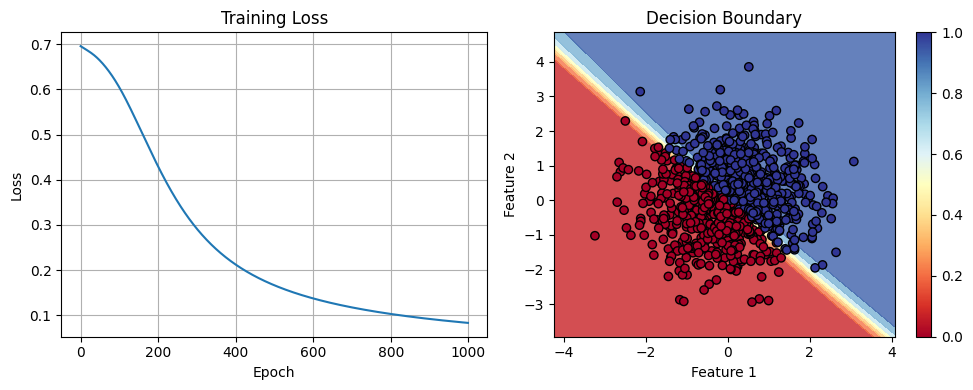


Comparing with other optimizers...


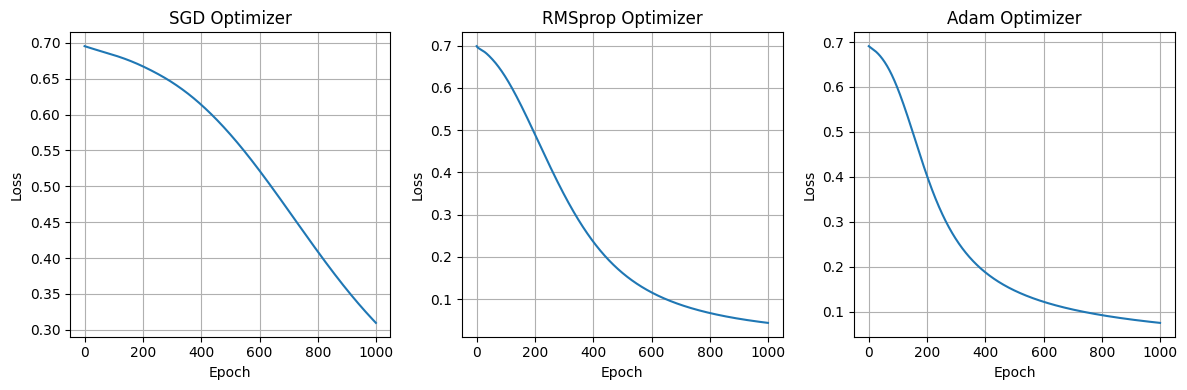


Demonstrating bias correction...
First 5 iterations (showing bias correction effect):
Step 1: t=0
  Parameter value: 0.999000

Step 2: t=1
  Bias correction factors: 0.1000, 0.0010
  Parameter value: 0.998000

Step 3: t=2
  Bias correction factors: 0.1900, 0.0020
  Parameter value: 0.997000

Step 4: t=3
  Bias correction factors: 0.2710, 0.0030
  Parameter value: 0.996000

Step 5: t=4
  Bias correction factors: 0.3439, 0.0040
  Parameter value: 0.995000



In [2]:


class Adam:
    """
    Adam (Adaptive Moment Estimation) Optimizer Implementation

    Paper: https://arxiv.org/abs/1412.6980
    """

    def __init__(self,
                 learning_rate: float = 0.001,
                 beta1: float = 0.9,
                 beta2: float = 0.999,
                 epsilon: float = 1e-8,
                 weight_decay: float = 0.0):
        """
        Initialize Adam optimizer

        Args:
            learning_rate: Step size (α)
            beta1: Decay rate for first moment (momentum)
            beta2: Decay rate for second moment (RMSprop-like)
            epsilon: Small constant for numerical stability
            weight_decay: L2 regularization coefficient
        """
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay

        # State variables
        self.m: Dict[str, np.ndarray] = {}  # First moment
        self.v: Dict[str, np.ndarray] = {}  # Second moment
        self.t = 0  # Time step

    def step(self, params: Dict[str, np.ndarray], grads: Dict[str, np.ndarray]):
        """
        Perform one optimization step

        Args:
            params: Dictionary of parameters {name: value}
            grads: Dictionary of gradients {name: gradient}
        """
        self.t += 1

        for name, param in params.items():
            if name not in grads:
                continue

            grad = grads[name]

            # Add weight decay (L2 regularization)
            if self.weight_decay > 0:
                grad = grad + self.weight_decay * param

            # Initialize moments if first time
            if name not in self.m:
                self.m[name] = np.zeros_like(param)
                self.v[name] = np.zeros_like(param)

            # Update first moment (momentum)
            self.m[name] = self.beta1 * self.m[name] + (1 - self.beta1) * grad

            # Update second moment (RMSprop-like)
            self.v[name] = self.beta2 * self.v[name] + (1 - self.beta2) * (grad ** 2)

            # Bias correction
            m_hat = self.m[name] / (1 - self.beta1 ** self.t)
            v_hat = self.v[name] / (1 - self.beta2 ** self.t)

            # Update parameters
            params[name] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

    def zero_grad(self):
        """Reset gradients (for consistency with PyTorch-like APIs)"""
        pass

    def get_state(self) -> Dict[str, Any]:
        """Get current optimizer state"""
        return {
            'learning_rate': self.learning_rate,
            'beta1': self.beta1,
            'beta2': self.beta2,
            'epsilon': self.epsilon,
            'weight_decay': self.weight_decay,
            't': self.t,
            'm': self.m.copy(),
            'v': self.v.copy()
        }


class SimpleNeuralNetwork:
    """Simple neural network for testing Adam optimizer"""

    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        # Initialize parameters
        self.params = {
            'W1': np.random.randn(input_size, hidden_size) * 0.1,
            'b1': np.zeros((1, hidden_size)),
            'W2': np.random.randn(hidden_size, output_size) * 0.1,
            'b2': np.zeros((1, output_size))
        }

        # Store activations for backprop
        self.cache = {}

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass"""
        # First layer
        z1 = np.dot(X, self.params['W1']) + self.params['b1']
        a1 = np.maximum(0, z1)  # ReLU activation

        # Second layer
        z2 = np.dot(a1, self.params['W2']) + self.params['b2']
        a2 = 1 / (1 + np.exp(-np.clip(z2, -250, 250)))  # Sigmoid activation

        # Store for backprop
        self.cache = {'X': X, 'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2}

        return a2

    def backward(self, y_true: np.ndarray) -> Dict[str, np.ndarray]:
        """Backward pass - compute gradients"""
        m = y_true.shape[0]

        # Get cached values
        X, z1, a1, z2, a2 = self.cache['X'], self.cache['z1'], self.cache['a1'], self.cache['z2'], self.cache['a2']

        # Output layer gradients
        dz2 = a2 - y_true
        dW2 = (1/m) * np.dot(a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)

        # Hidden layer gradients
        da1 = np.dot(dz2, self.params['W2'].T)
        dz1 = da1 * (z1 > 0)  # ReLU derivative
        dW1 = (1/m) * np.dot(X.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)

        return {
            'W1': dW1,
            'b1': db1,
            'W2': dW2,
            'b2': db2
        }

    def compute_loss(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        """Compute binary cross-entropy loss"""
        m = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        loss = -(1/m) * np.sum(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        return loss


def test_adam_optimizer():
    """Test Adam optimizer on a simple dataset"""

    # Generate synthetic data
    np.random.seed(42)
    n_samples = 1000
    X = np.random.randn(n_samples, 2)
    y = ((X[:, 0] + X[:, 1]) > 0).astype(float).reshape(-1, 1)

    # Initialize network and optimizer
    network = SimpleNeuralNetwork(input_size=2, hidden_size=10, output_size=1)
    optimizer = Adam(learning_rate=0.001, beta1=0.9, beta2=0.999)

    # Training loop
    epochs = 1000
    losses = []

    for epoch in range(epochs):
        # Forward pass
        y_pred = network.forward(X)
        loss = network.compute_loss(y_pred, y)
        losses.append(loss)

        # Backward pass
        grads = network.backward(y)

        # Update parameters
        optimizer.step(network.params, grads)

        if epoch % 100 == 0:
            accuracy = np.mean((y_pred > 0.5) == y)
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    # Plot training loss
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot decision boundary
    plt.subplot(1, 2, 2)
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = network.forward(mesh_points)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.colorbar(scatter)
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.tight_layout()
    plt.show()


def compare_optimizers():
    """Compare Adam with SGD and RMSprop"""

    # Generate synthetic data
    np.random.seed(42)
    n_samples = 1000
    X = np.random.randn(n_samples, 2)
    y = ((X[:, 0] + X[:, 1]) > 0).astype(float).reshape(-1, 1)

    # Simple SGD optimizer for comparison
    class SGD:
        def __init__(self, learning_rate=0.01):
            self.learning_rate = learning_rate

        def step(self, params, grads):
            for name, param in params.items():
                if name in grads:
                    params[name] -= self.learning_rate * grads[name]

    # Simple RMSprop optimizer for comparison
    class RMSprop:
        def __init__(self, learning_rate=0.001, beta=0.9, epsilon=1e-8):
            self.learning_rate = learning_rate
            self.beta = beta
            self.epsilon = epsilon
            self.v = {}

        def step(self, params, grads):
            for name, param in params.items():
                if name not in grads:
                    continue

                grad = grads[name]

                if name not in self.v:
                    self.v[name] = np.zeros_like(param)

                self.v[name] = self.beta * self.v[name] + (1 - self.beta) * (grad ** 2)
                params[name] -= self.learning_rate * grad / (np.sqrt(self.v[name]) + self.epsilon)

    # Test different optimizers
    optimizers = {
        'SGD': SGD(learning_rate=0.01),
        'RMSprop': RMSprop(learning_rate=0.001),
        'Adam': Adam(learning_rate=0.001)
    }

    plt.figure(figsize=(12, 4))

    for i, (name, optimizer) in enumerate(optimizers.items()):
        # Fresh network for each optimizer
        network = SimpleNeuralNetwork(input_size=2, hidden_size=10, output_size=1)

        losses = []
        epochs = 1000

        for epoch in range(epochs):
            y_pred = network.forward(X)
            loss = network.compute_loss(y_pred, y)
            losses.append(loss)

            grads = network.backward(y)
            optimizer.step(network.params, grads)

        plt.subplot(1, 3, i+1)
        plt.plot(losses)
        plt.title(f'{name} Optimizer')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    print("Testing Adam Optimizer Implementation")
    print("=" * 50)

    # Test basic functionality
    test_adam_optimizer()

    print("\nComparing with other optimizers...")
    compare_optimizers()

    # Demonstrate bias correction effect
    print("\nDemonstrating bias correction...")
    adam_with_correction = Adam(learning_rate=0.001)

    # Simulate first few iterations
    params = {'w': np.array([1.0])}
    grads = {'w': np.array([0.1])}

    print("First 5 iterations (showing bias correction effect):")
    for i in range(5):
        print(f"Step {i+1}: t={adam_with_correction.t}")
        if 'w' in adam_with_correction.m:
            bias_correction_1 = 1 - adam_with_correction.beta1 ** adam_with_correction.t
            bias_correction_2 = 1 - adam_with_correction.beta2 ** adam_with_correction.t
            print(f"  Bias correction factors: {bias_correction_1:.4f}, {bias_correction_2:.4f}")

        adam_with_correction.step(params, grads)
        print(f"  Parameter value: {params['w'][0]:.6f}")
        print()